# RECOMMENDATION SYSTEM TO START A RESTAURANT BUSINESS IN NORTHERN VIRGINIA

## Importing python libraries and dependencies

In [1]:
import numpy as np
import pandas as pd
from geopy.geocoders import Nominatim
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import requests
from pandas.io.json import json_normalize
!pip install folium
import folium
!pip install geopy


import matplotlib.pyplot as plt
%matplotlib inline


print('Libraries imported.')

Libraries imported.


## Data cleaning and extracting

In [2]:
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_56f64297d4744e8694d897323202958a = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='NeKh3tGhOYSovuf2ejpjbPam8NsDo0JTyRVHySQr_WJm',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_56f64297d4744e8694d897323202958a.get_object(Bucket='courseracapstone-donotdelete-pr-yv4yfnxdaywifw',Key='geonames-postal-code.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_1 = pd.read_csv(body)
df_data_1.head()

postal code  place name admin name2  latitude  longitude
0        23358   Hacksneck    Accomack   37.6393   -75.8650
1        24522  Appomattox  Appomattox   37.3530   -78.8224
2        22205   Arlington   Arlington   38.8836   -77.1395
3        22214   Arlington   Arlington   38.8688   -77.0739
4        22952   Lyndhurst     Augusta   37.9744   -78.9361

In [3]:
#back up 
vadf=df_data_1

In [4]:
#Renaming columns 
vadf = vadf.rename(index=str, columns={'postal code':'Postal Code','place name':'City','admin name2':'County'})
vadf.shape
vadf.head() 

Postal Code        City      County  latitude  longitude
0        23358   Hacksneck    Accomack   37.6393   -75.8650
1        24522  Appomattox  Appomattox   37.3530   -78.8224
2        22205   Arlington   Arlington   38.8836   -77.1395
3        22214   Arlington   Arlington   38.8688   -77.0739
4        22952   Lyndhurst     Augusta   37.9744   -78.9361

## Getting the coordinates of Virginia State

In [5]:
# get the coordinates of Virginia 
address = 'Virginia, USA'

geolocator = Nominatim(user_agent="my-app")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Virginia {}, {}.'.format(latitude, longitude))


The geograpical coordinate of Virginia 37.1232245, -78.4927721.


In [6]:
# save the DataFrame as CSV file
vadf.to_csv("vadf.csv", index=False)

## Creating a map of Virginia with Counties superimposed on top

In [7]:
# create map of Virginia using latitude and longitude values
map_va = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, city, county in zip(vadf['latitude'], vadf['longitude'], vadf['City'], vadf['County']):
    label = '{}'.format(city,county)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_va)  
    
map_va

## Let us focus on the counties in Northern Virginia

In [8]:
NoVA= ["Prince William","Fairfax","Stafford", "Loudoun", "Arlington","City of Alexandria", "Manassas (city) ", "Manassas Park (city)", "Falls Church (city)", "Fairfax (city)"]

#copy1
NoVA_df=vadf

In [9]:
# create a new DataFrame with only Counties in Northern Virginia
NoVA_df = NoVA_df[NoVA_df['County'].isin(NoVA)].reset_index(drop=True)
print(NoVA_df.shape)
NoVA_df.head()

(187, 5)


Postal Code       City     County  latitude  longitude
0        22205  Arlington  Arlington   38.8836   -77.1395
1        22214  Arlington  Arlington   38.8688   -77.0739
2        20124    Clifton    Fairfax   38.7818   -77.3818
3        20192    Herndon    Fairfax   38.8318   -77.2888
4        22032    Fairfax    Fairfax   38.8177   -77.2925

In [10]:
# create map of NOVA using latitude and longitude values
map_NOVA = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, city, county in zip(NoVA_df['latitude'], NoVA_df['longitude'], NoVA_df['City'], NoVA_df['County']):
    label = '{}'.format(city,county)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_NOVA)  
    
map_NOVA

## Use the Foursquare API to explore the neighborhoods

In [11]:
#Utilizing the Foursquare API to explore the neighborhoods and segment them
#Defining Foursquare Credentials and Version
#1
CLIENT_ID = 'H20TXB0O4MGME2BAVRIZ3PCSNCBO44SXDLBOIN2OBQYATCHV' # your Foursquare ID
CLIENT_SECRET = 'XVJLW2ISYPM2KJNEUCFVG0E0W5G0I4VOAE4QCTIPE2RQRVYM' # your Foursquare Secret

VERSION = '20210210'

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: H20TXB0O4MGME2BAVRIZ3PCSNCBO44SXDLBOIN2OBQYATCHV
CLIENT_SECRET:XVJLW2ISYPM2KJNEUCFVG0E0W5G0I4VOAE4QCTIPE2RQRVYM


## Now, let's get the top 100 venues that are within a radius of 500 meters.

In [12]:
#Creating a dataframe with all the venues information provided by foursquare for the given latitude and longitude values
#set variables
radius=500
LIMIT=100

def getNearbyVenues(names, latitudes, longitudes, radius=500):

    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
       
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [13]:
# Using the above function on each neighborhood and create a new dataframe called NOVA_venues

NOVA_venues = getNearbyVenues(names=NoVA_df['City'],
                                   latitudes=NoVA_df['latitude'],
                                   longitudes=NoVA_df['longitude']
                                  )

Arlington
Arlington
Clifton
Herndon
Fairfax
Falls Church
Mc Lean
Middleburg
Round Hill
Ashburn
Sterling
Leesburg
Nokesville
Dumfries
Occoquan
Fredericksburg
Alexandria
Manassas
Manassas
Manassas
Arlington
Arlington
Centreville
Centreville
Annandale
Merrifield
Alexandria
Hamilton
Sterling
Falls Church
Arlington
Arlington
Chantilly
Reston
Fairfax
Great Falls
Mc Lean
Newington
Springfield
Alexandria
Dulles
Round Hill
Leesburg
Gainesville
Triangle
Ruby
Arlington
Arlington
Arlington
Burke
Merrifield
Springfield
Ashburn
Sterling
Dulles
Haymarket
Woodbridge
Alexandria
Fairfax
Fort Myer
Centreville
Merrifield
Springfield
Alexandria
Middleburg
Philomont
Hartwood
Alexandria
Alexandria
Chantilly
Herndon
Burke
Dunn Loring
Fairfax Station
Falls Church
Fort Belvoir
Greenway
Mount Vernon
Ashburn
Sterling
Leesburg
Gainesville
Dumfries
Woodbridge
Fredericksburg
Alexandria
Alexandria
Fairfax
Arlington
Arlington
Herndon
Reston
Reston
Mc Lean
Mc Lean
Springfield
Alexandria
Sterling
Fredericksburg
Stafford

In [14]:
print(NOVA_venues.shape)
NOVA_venues.head()

(2919, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0    Arlington                38.8836                -77.1395   
1    Arlington                38.8836                -77.1395   
2    Arlington                38.8836                -77.1395   
3    Arlington                38.8836                -77.1395   
4    Arlington                38.8836                -77.1395   

                                Venue  Venue Latitude  Venue Longitude  \
0                   The Italian Store       38.885179       -77.140250   
1  Toby's Homemade Ice Cream & Coffee       38.885283       -77.140743   
2         Westover Market Beer Garden       38.885637       -77.141413   
3                       Lost Dog Cafe       38.885656       -77.141698   
4                      Stray Cat Café       38.885387       -77.141564   

        Venue Category  
0   Italian Restaurant  
1       Ice Cream Shop  
2          Beer Garden  
3       Sandwich Place  
4  American Restaurant

In [15]:
# Number of venues for each neighborhood
NOVA_venues.groupby('Neighborhood')
print('There are {} uniques categories.'.format(len(NOVA_venues['Venue Category'].unique())))

There are 276 uniques categories.


## Extracting only restaurants from venue category list and creating a dataframe "NOVA_restaurants"

In [16]:
NOVA_restaurants = NOVA_venues[NOVA_venues['Venue Category'].str.contains("Restaurant")]
print(NOVA_restaurants.shape)

(703, 7)


In [17]:
print('There are {} unique categories or cusines available in Northern Virginia.'.format(len(NOVA_restaurants['Venue Category'].unique())))

There are 50 unique categories or cusines available in Northern Virginia.


## Analysis of each neighborhood

In [18]:
# one hot encoding
NOVA_onehot = pd.get_dummies(NOVA_restaurants[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
NOVA_onehot['Neighborhood'] = NOVA_restaurants['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [NOVA_onehot.columns[-1]] + list(NOVA_onehot.columns[:-1])
NOVA_onehot = NOVA_onehot[fixed_columns]

NOVA_onehot.head()

Neighborhood  Afghan Restaurant  African Restaurant  American Restaurant  \
0     Arlington                  0                   0                    0   
4     Arlington                  0                   0                    1   
7     Arlington                  0                   0                    0   
8     Arlington                  0                   0                    0   
26    Arlington                  0                   0                    0   

    Asian Restaurant  Belgian Restaurant  Cajun / Creole Restaurant  \
0                  0                   0                          0   
4                  0                   0                          0   
7                  0                   0                          0   
8                  0                   0                          0   
26                 0                   0                          0   

    Caribbean Restaurant  Chinese Restaurant  Comfort Food Restaurant  ...  \
0                      0                   0                        0  ...   
4                      0                   0                        0  ...   
7                      0                   0                        0  ...   
8                      0                   0                        0  ...   
26                     0                   0                        0  ...   

    South Indian Restaurant  Southern / Soul Food Restaurant  \
0                         0                                0   
4                         0                                0   
7                         0                                0   
8                         0                                0   
26                        0                                0   

    Spanish Restaurant  Sushi Restaurant  Tapas Restaurant  \
0                    0                 0                 0   
4                    0                 0                 0   
7                    0                 0                 0   
8                    0                 0                 0   
26                   0                 0                 0   

    Tex-Mex Restaurant  Thai Restaurant  Turkish Restaurant  \
0                    0                0                   0   
4                    0                0                   0   
7                    0                1                   0   
8                    0                0                   0   
26                   0                0                   0   

    Vegetarian / Vegan Restaurant  Vietnamese Restaurant  
0                               0                      0  
4                               0                      0  
7                               0                      0  
8                               0                      0  
26                              0                      0  

[5 rows x 51 columns]

In [19]:
print('There are {} restaurants in NOVA with {} different style of cuisines.'.format(NOVA_onehot.shape[0],(NOVA_onehot.shape[1]-1)))

There are 703 restaurants in NOVA with 50 different style of cuisines.


## Grouping rows by neighborhood and taking the mean of the frequency of occurrence of each category/restaurants

In [20]:
NOVA_grouped = NOVA_onehot.groupby('Neighborhood').mean().reset_index()
NOVA_grouped

Neighborhood  Afghan Restaurant  African Restaurant  American Restaurant  \
0      Alexandria           0.007937            0.007937             0.119048   
1       Annandale           0.000000            0.000000             1.000000   
2       Arlington           0.000000            0.012862             0.163987   
3         Ashburn           0.000000            0.000000             0.000000   
4         Bristow           0.000000            0.000000             0.142857   
5       Chantilly           0.000000            0.000000             0.200000   
6         Clifton           0.000000            0.000000             0.333333   
7          Dulles           0.000000            0.000000             0.000000   
8        Dumfries           0.000000            0.000000             0.000000   
9         Fairfax           0.000000            0.000000             0.000000   
10   Falls Church           0.000000            0.000000             0.045455   
11   Fort Belvoir           0.000000            0.000000             0.000000   
12      Fort Myer           0.000000            0.000000             0.000000   
13  Garrisonville           0.000000            0.000000             0.000000   
14      Haymarket           0.000000            0.000000             0.000000   
15        Herndon           0.000000            0.000000             0.200000   
16       Leesburg           0.000000            0.000000             0.333333   
17         Lorton           0.000000            0.000000             0.000000   
18   Lovettsville           0.000000            0.000000             0.000000   
19       Manassas           0.000000            0.000000             0.000000   
20        Mc Lean           0.000000            0.000000             0.037736   
21     Merrifield           0.000000            0.000000             0.027027   
22     Middleburg           0.000000            0.000000             0.666667   
23      Newington           0.000000            0.000000             0.500000   
24       Occoquan           0.000000            0.000000             0.333333   
25       Quantico           0.000000            0.000000             0.333333   
26         Reston           0.000000            0.000000             0.000000   
27    Springfield           0.000000            0.000000             0.090909   
28       Stafford           0.000000            0.000000             0.000000   
29       Sterling           0.000000            0.000000             0.083333   
30     Woodbridge           0.000000            0.000000             0.000000   

    Asian Restaurant  Belgian Restaurant  Cajun / Creole Restaurant  \
0           0.031746            0.000000                   0.023810   
1           0.000000            0.000000                   0.000000   
2           0.000000            0.000000                   0.000000   
3           0.000000            0.000000                   0.000000   
4           0.000000            0.000000                   0.000000   
5           0.000000            0.000000                   0.000000   
6           0.000000            0.000000                   0.000000   
7           0.333333            0.000000                   0.000000   
8           0.000000            0.000000                   0.000000   
9           0.000000            0.000000                   0.000000   
10          0.000000            0.000000                   0.045455   
11          0.000000            0.000000                   0.000000   
12          0.000000            0.000000                   0.083333   
13          0.000000            0.000000                   0.000000   
14          0.333333            0.000000                   0.000000   
15          0.000000            0.000000                   0.000000   
16          0.000000            0.000000                   0.000000   
17          0.000000            0.000000                   0.000000   
18          0.000000            0.000000                   0.00

In [21]:
NOVA_grouped.shape

(31, 51)

## Top 3 restaurants for each Neighborhood based on cuisine

In [22]:
num_top_rest = 3

for hood in NOVA_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = NOVA_grouped[NOVA_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_rest))
    print('\n')

----Alexandria----
                 venue  freq
0  American Restaurant  0.12
1   Mexican Restaurant  0.07
2   Italian Restaurant  0.07


----Annandale----
                 venue  freq
0  American Restaurant   1.0
1    Afghan Restaurant   0.0
2   Seafood Restaurant   0.0


----Arlington----
                      venue  freq
0       American Restaurant  0.16
1        Mexican Restaurant  0.11
2  Mediterranean Restaurant  0.09


----Ashburn----
                venue  freq
0  Chinese Restaurant   1.0
1   Afghan Restaurant   0.0
2  Seafood Restaurant   0.0


----Bristow----
                venue  freq
0  Mexican Restaurant  0.29
1     Thai Restaurant  0.14
2    Sushi Restaurant  0.14


----Chantilly----
                  venue  freq
0  Fast Food Restaurant   0.6
1   American Restaurant   0.2
2   Japanese Restaurant   0.1


----Clifton----
                 venue  freq
0   Italian Restaurant  0.67
1  American Restaurant  0.33
2    Afghan Restaurant  0.00


----Dulles----
                  venu

## Creating a new dataframe with the above results for each neighborhood

In [23]:
# A function to sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [24]:
#Creating a new dataframe and displaying the top 10 restaurants based on occurance and cuisine for each neighborhood
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = NOVA_grouped['Neighborhood']


for ind in np.arange(NOVA_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(NOVA_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood 1st Most Common Venue  2nd Most Common Venue  \
0   Alexandria   American Restaurant     Mexican Restaurant   
1    Annandale   American Restaurant  Vietnamese Restaurant   
2    Arlington   American Restaurant     Mexican Restaurant   
3      Ashburn    Chinese Restaurant  Vietnamese Restaurant   
4      Bristow    Mexican Restaurant  Vietnamese Restaurant   

      3rd Most Common Venue 4th Most Common Venue  \
0        Italian Restaurant      Greek Restaurant   
1      Ethiopian Restaurant   Japanese Restaurant   
2  Mediterranean Restaurant     Indian Restaurant   
3      Ethiopian Restaurant   Japanese Restaurant   
4           Thai Restaurant   American Restaurant   

             5th Most Common Venue 6th Most Common Venue  \
0  Southern / Soul Food Restaurant  Fast Food Restaurant   
1               Italian Restaurant     Indian Restaurant   
2                       Restaurant      Sushi Restaurant   
3               Italian Restaurant     Indian Restaurant   
4                 Sushi Restaurant    Chinese Restaurant   

      7th Most Common Venue 8th Most Common Venue    9th Most Common Venue  \
0  Mediterranean Restaurant            Restaurant  New American Restaurant   
1      Himalayan Restaurant      Greek Restaurant        German Restaurant   
2        Chinese Restaurant    Italian Restaurant          Thai Restaurant   
3      Himalayan Restaurant      Greek Restaurant        German Restaurant   
4      Ethiopian Restaurant     Indian Restaurant     Himalayan Restaurant   

    10th Most Common Venue  
0          Thai Restaurant  
1        French Restaurant  
2  New American Restaurant  
3        French Restaurant  
4         Greek Restaurant

# Custering Neighborhoods using K-means

## Finding the best k

In [25]:
# Creating new dataframe to determine best k value by dropping first column
NOVA_clustering_testing = NOVA_grouped.drop('Neighborhood', 1)

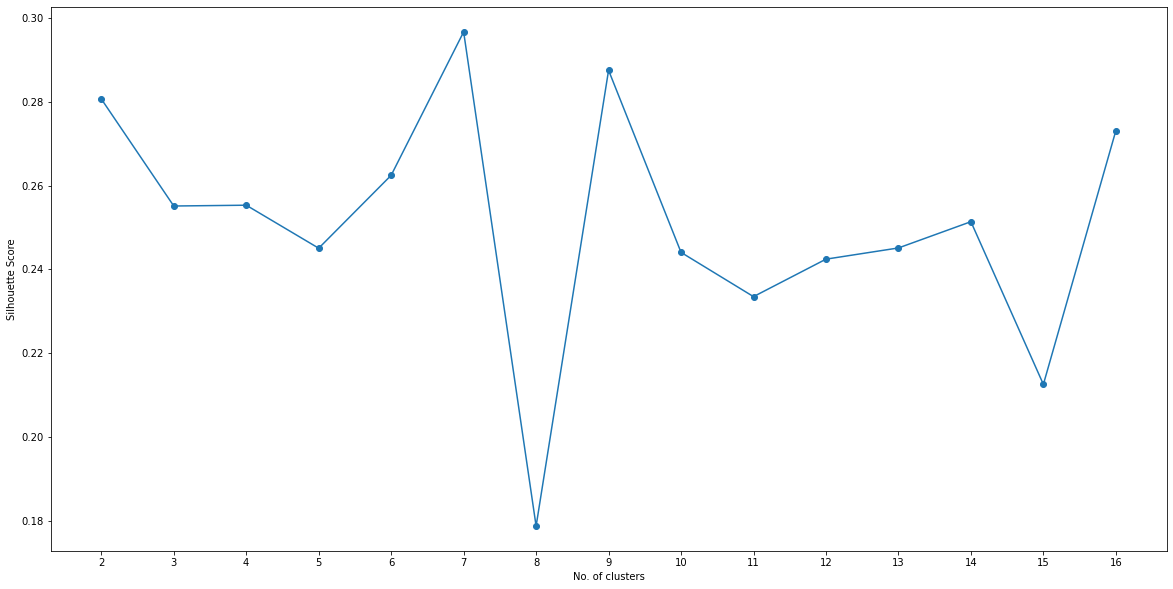

In [26]:
def plot(x, y, xlabel, ylabel):
    plt.figure(figsize=(20,10))
    plt.plot(np.arange(2, x), y, 'o-')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(np.arange(2, x))
    plt.show()
    
indices = []
scores = []
max_range = 17

for kclusters in range(2, max_range) :
    
    # Run k-means clustering
    lct = NOVA_clustering_testing
    kmeans = KMeans(n_clusters = kclusters, init = 'k-means++', random_state = 0).fit_predict(lct)
    
    # Gets the score for the clustering operation performed
    score = silhouette_score(lct, kmeans)
    
    # Appending the index and score to the respective lists
    indices.append(kclusters)
    scores.append(score)
    

plot(max_range, scores, "No. of clusters", "Silhouette Score")

## From the graph the optimal number is found out to be considered for our clustering

In [27]:
#From the graph the optimal number is found out to be considered for our clustering
opt = np.argmax(scores) + 2 # Finds the optimal value
opt

7

In [28]:
# set number of clusters
kclusters = opt

NOVA_grouped_clustering = NOVA_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(NOVA_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 0, 1, 6, 1, 3, 1, 3, 2, 1], dtype=int32)

## Creating a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood

In [29]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

NOVA_merged = NOVA_restaurants

# merge NOVA_grouped to add latitude/longitude for each neighborhood
NOVA_merged = NOVA_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
NOVA_merged.fillna(0)
NOVA_merged.head() # check the last columns!

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0     Arlington                38.8836                -77.1395   
4     Arlington                38.8836                -77.1395   
7     Arlington                38.8836                -77.1395   
8     Arlington                38.8836                -77.1395   
26    Arlington                38.8688                -77.0739   

                   Venue  Venue Latitude  Venue Longitude  \
0      The Italian Store       38.885179       -77.140250   
4         Stray Cat Café       38.885387       -77.141564   
7               Thai Noy       38.885660       -77.141761   
8       Lebanese Taverna       38.885715       -77.142146   
26  Dama Pastry And Cafe       38.866990       -77.070650   

               Venue Category  Cluster Labels 1st Most Common Venue  \
0          Italian Restaurant               1   American Restaurant   
4         American Restaurant               1   American Restaurant   
7             Thai Restaurant               1   American Restaurant   
8   Middle Eastern Restaurant               1   American Restaurant   
26       Ethiopian Restaurant               1   American Restaurant   

   2nd Most Common Venue     3rd Most Common Venue 4th Most Common Venue  \
0     Mexican Restaurant  Mediterranean Restaurant     Indian Restaurant   
4     Mexican Restaurant  Mediterranean Restaurant     Indian Restaurant   
7     Mexican Restaurant  Mediterranean Restaurant     Indian Restaurant   
8     Mexican Restaurant  Mediterranean Restaurant     Indian Restaurant   
26    Mexican Restaurant  Mediterranean Restaurant     Indian Restaurant   

   5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
0             Restaurant      Sushi Restaurant    Chinese Restaurant   
4             Restaurant      Sushi Restaurant    Chinese Restaurant   
7             Restaurant      Sushi Restaurant    Chinese Restaurant   
8             Restaurant      Sushi Restaurant    Chinese Restaurant   
26            Restaurant      Sushi Restaurant    Chinese Restaurant   

   8th Most Common Venue 9th Most Common Venue   10th Most Common Venue  
0     Italian Restaurant       Thai Restaurant  New American Restaurant  
4     Italian Restaurant       Thai Restaurant  New American Restaurant  
7     Italian Restaurant       Thai Restaurant  New American Restaurant  
8     Italian Restaurant       Thai Restaurant  New American Restaurant  
26    Italian Restaurant       Thai Restaurant  New American Restaurant

## Number of venues belonging to each cluster

In [30]:
NOVA_merged['Cluster Labels'].value_counts()

1    669
3     19
0      7
2      4
6      2
5      1
4      1
Name: Cluster Labels, dtype: int64

## Creating map for each cluster for better visualization

In [31]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
count = 0
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, vc in zip(NOVA_merged['Venue Latitude'], NOVA_merged['Venue Longitude'], NOVA_merged['Venue'], NOVA_merged['Cluster Labels'], NOVA_merged['Venue Category']):
    label = folium.Popup(str(poi) +' (' +str(vc) + ') ['+ str(cluster)+']', parse_html=True)

    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
    count += 1
map_clusters


## Final analysis of each cluster
Now, examining each cluster and determining the discriminating restaurants that distinguish each cluster. Based on the restaurants, we can then assign a name to each cluster.

### Cluster 0

In [32]:
c1 = NOVA_merged.loc[NOVA_merged['Cluster Labels'] == 0, NOVA_merged.columns[[0]+list(range(8, NOVA_merged.shape[1]))]]
#c1.drop_duplicates()
c1

Neighborhood 1st Most Common Venue  2nd Most Common Venue  \
79     Middleburg   American Restaurant     Seafood Restaurant   
83     Middleburg   American Restaurant     Seafood Restaurant   
86     Middleburg   American Restaurant     Seafood Restaurant   
326     Annandale   American Restaurant  Vietnamese Restaurant   
994    Middleburg   American Restaurant     Seafood Restaurant   
998    Middleburg   American Restaurant     Seafood Restaurant   
1001   Middleburg   American Restaurant     Seafood Restaurant   

      3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
79    Vietnamese Restaurant  Ethiopian Restaurant    Italian Restaurant   
83    Vietnamese Restaurant  Ethiopian Restaurant    Italian Restaurant   
86    Vietnamese Restaurant  Ethiopian Restaurant    Italian Restaurant   
326    Ethiopian Restaurant   Japanese Restaurant    Italian Restaurant   
994   Vietnamese Restaurant  Ethiopian Restaurant    Italian Restaurant   
998   Vietnamese Restaurant  Ethiopian Restaurant    Italian Restaurant   
1001  Vietnamese Restaurant  Ethiopian Restaurant    Italian Restaurant   

     6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
79       Indian Restaurant  Himalayan Restaurant      Greek Restaurant   
83       Indian Restaurant  Himalayan Restaurant      Greek Restaurant   
86       Indian Restaurant  Himalayan Restaurant      Greek Restaurant   
326      Indian Restaurant  Himalayan Restaurant      Greek Restaurant   
994      Indian Restaurant  Himalayan Restaurant      Greek Restaurant   
998      Indian Restaurant  Himalayan Restaurant      Greek Restaurant   
1001     Indian Restaurant  Himalayan Restaurant      Greek Restaurant   

     9th Most Common Venue 10th Most Common Venue  
79       German Restaurant      French Restaurant  
83       German Restaurant      French Restaurant  
86       German Restaurant      French Restaurant  
326      German Restaurant      French Restaurant  
994      German Restaurant      French Restaurant  
998      German Restaurant      French Restaurant  
1001     German Restaurant      French Restaurant

In [33]:
c1_table = NOVA_merged.loc[NOVA_merged['Cluster Labels'] == 0, NOVA_merged.columns[[0]+[3]+[4]+[5]+list(range(8, NOVA_merged.shape[1]))]]
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=15)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, neigh in zip(c1_table['Venue Latitude'], c1_table['Venue Longitude'], c1_table['Venue'], c1_table['Neighborhood'] ):
    label = folium.Popup(str(poi) +', ' +str(neigh), parse_html=True)

    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
    count += 1
map_clusters

### Cluster 1

In [34]:
c2 = NOVA_merged.loc[NOVA_merged['Cluster Labels'] == 1, NOVA_merged.columns[[0]+list(range(8, NOVA_merged.shape[1]))]]
#c2.drop_duplicates()
c2

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0       Arlington   American Restaurant    Mexican Restaurant   
4       Arlington   American Restaurant    Mexican Restaurant   
7       Arlington   American Restaurant    Mexican Restaurant   
8       Arlington   American Restaurant    Mexican Restaurant   
26      Arlington   American Restaurant    Mexican Restaurant   
...           ...                   ...                   ...   
2904   Alexandria   American Restaurant    Mexican Restaurant   
2905   Alexandria   American Restaurant    Mexican Restaurant   
2906   Alexandria   American Restaurant    Mexican Restaurant   
2907   Alexandria   American Restaurant    Mexican Restaurant   
2918   Alexandria   American Restaurant    Mexican Restaurant   

         3rd Most Common Venue 4th Most Common Venue  \
0     Mediterranean Restaurant     Indian Restaurant   
4     Mediterranean Restaurant     Indian Restaurant   
7     Mediterranean Restaurant     Indian Restaurant   
8     Mediterranean Restaurant     Indian Restaurant   
26    Mediterranean Restaurant     Indian Restaurant   
...                        ...                   ...   
2904        Italian Restaurant      Greek Restaurant   
2905        Italian Restaurant      Greek Restaurant   
2906        Italian Restaurant      Greek Restaurant   
2907        Italian Restaurant      Greek Restaurant   
2918        Italian Restaurant      Greek Restaurant   

                5th Most Common Venue 6th Most Common Venue  \
0                          Restaurant      Sushi Restaurant   
4                          Restaurant      Sushi Restaurant   
7                          Restaurant      Sushi Restaurant   
8                          Restaurant      Sushi Restaurant   
26                         Restaurant      Sushi Restaurant   
...                               ...                   ...   
2904  Southern / Soul Food Restaurant  Fast Food Restaurant   
2905  Southern / Soul Food Restaurant  Fast Food Restaurant   
2906  Southern / Soul Food Restaurant  Fast Food Restaurant   
2907  Southern / Soul Food Restaurant  Fast Food Restaurant   
2918  Southern / Soul Food Restaurant  Fast Food Restaurant   

         7th Most Common Venue 8th Most Common Venue    9th Most Common Venue  \
0           Chinese Restaurant    Italian Restaurant          Thai Restaurant   
4           Chinese Restaurant    Italian Restaurant          Thai Restaurant   
7           Chinese Restaurant    Italian Restaurant          Thai Restaurant   
8           Chinese Restaurant    Italian Restaurant          Thai Restaurant   
26          Chinese Restaurant    Italian Restaurant          Thai Restaurant   
...                        ...                   ...                      ...   
2904  Mediterranean Restaurant            Restaurant  New American Restaurant   
2905  Mediterranean Restaurant            Restaurant  New American Restaurant   
2906  Mediterranean Restaurant            Restaurant  New American Restaurant   
2907  Mediterranean Restaurant            Restaurant  New American Restaurant   
2918  Mediterranean Restaurant            Restaurant  New American Restaurant   

       10th Most Common Venue  
0     New American Restaurant  
4     New American Restaurant  
7     New American Restaurant  
8     New American Restaurant  
26    New American Restaurant  
...                       ...  
2904          Thai Restaurant  
2905          Thai Restaurant  
2906          Thai Restaurant  
2907          Thai Restaurant  
2918          Thai Restaurant  

[669 rows x 11 columns]

In [35]:
c2_table = NOVA_merged.loc[NOVA_merged['Cluster Labels'] == 1, NOVA_merged.columns[[0]+[3]+[4]+[5]+list(range(8, NOVA_merged.shape[1]))]]
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, neigh in zip(c2_table['Venue Latitude'], c2_table['Venue Longitude'], c2_table['Venue'], c2_table['Neighborhood'] ):
    label = folium.Popup(str(poi) +', ' +str(neigh), parse_html=True)

    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7).add_to(map_clusters)
    count += 1
map_clusters

### Cluster 2

In [36]:
c3 = NOVA_merged.loc[NOVA_merged['Cluster Labels'] == 2, NOVA_merged.columns[[0]+list(range(8, NOVA_merged.shape[1]))]]
c3
#c3.drop_duplicates()

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
1124     Dumfries      Greek Restaurant    Chinese Restaurant   
1125     Dumfries      Greek Restaurant    Chinese Restaurant   
1841       Lorton      Greek Restaurant   Filipino Restaurant   
1843       Lorton      Greek Restaurant   Filipino Restaurant   

      3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
1124  Vietnamese Restaurant  Ethiopian Restaurant   Japanese Restaurant   
1125  Vietnamese Restaurant  Ethiopian Restaurant   Japanese Restaurant   
1841  Vietnamese Restaurant  Ethiopian Restaurant   Japanese Restaurant   
1843  Vietnamese Restaurant  Ethiopian Restaurant   Japanese Restaurant   

     6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
1124    Italian Restaurant     Indian Restaurant  Himalayan Restaurant   
1125    Italian Restaurant     Indian Restaurant  Himalayan Restaurant   
1841    Italian Restaurant     Indian Restaurant  Himalayan Restaurant   
1843    Italian Restaurant     Indian Restaurant  Himalayan Restaurant   

     9th Most Common Venue 10th Most Common Venue  
1124     German Restaurant      French Restaurant  
1125     German Restaurant      French Restaurant  
1841     German Restaurant      French Restaurant  
1843     German Restaurant      French Restaurant

In [37]:
c3_table = NOVA_merged.loc[NOVA_merged['Cluster Labels'] == 2, NOVA_merged.columns[[0]+[3]+[4]+[5]+list(range(8, NOVA_merged.shape[1]))]]
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, neigh in zip(c3_table['Venue Latitude'], c3_table['Venue Longitude'], c3_table['Venue'], c3_table['Neighborhood'] ):
    label = folium.Popup(str(poi) +', ' +str(neigh), parse_html=True)

    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7).add_to(map_clusters)
    count += 1
map_clusters

### Cluster 3

In [38]:
c4 = NOVA_merged.loc[NOVA_merged['Cluster Labels'] == 3, NOVA_merged.columns[[0]+list(range(8, NOVA_merged.shape[1]))]]
c4
#c4.drop_duplicates()

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
526       Chantilly  Fast Food Restaurant   American Restaurant   
528       Chantilly  Fast Food Restaurant   American Restaurant   
529       Chantilly  Fast Food Restaurant   American Restaurant   
533       Chantilly  Fast Food Restaurant   American Restaurant   
538       Chantilly  Fast Food Restaurant   American Restaurant   
539       Chantilly  Fast Food Restaurant   American Restaurant   
543       Chantilly  Fast Food Restaurant   American Restaurant   
545       Chantilly  Fast Food Restaurant   American Restaurant   
548       Chantilly  Fast Food Restaurant   American Restaurant   
549       Chantilly  Fast Food Restaurant   American Restaurant   
609       Newington   American Restaurant  Fast Food Restaurant   
612       Newington   American Restaurant  Fast Food Restaurant   
802          Dulles      Kebab Restaurant      Asian Restaurant   
809          Dulles      Kebab Restaurant      Asian Restaurant   
815          Dulles      Kebab Restaurant      Asian Restaurant   
1084   Fort Belvoir    Chinese Restaurant  Fast Food Restaurant   
1089   Fort Belvoir    Chinese Restaurant  Fast Food Restaurant   
2890  Garrisonville    Chinese Restaurant  Fast Food Restaurant   
2891  Garrisonville    Chinese Restaurant  Fast Food Restaurant   

      3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
526     Japanese Restaurant    Mexican Restaurant  Ethiopian Restaurant   
528     Japanese Restaurant    Mexican Restaurant  Ethiopian Restaurant   
529     Japanese Restaurant    Mexican Restaurant  Ethiopian Restaurant   
533     Japanese Restaurant    Mexican Restaurant  Ethiopian Restaurant   
538     Japanese Restaurant    Mexican Restaurant  Ethiopian Restaurant   
539     Japanese Restaurant    Mexican Restaurant  Ethiopian Restaurant   
543     Japanese Restaurant    Mexican Restaurant  Ethiopian Restaurant   
545     Japanese Restaurant    Mexican Restaurant  Ethiopian Restaurant   
548     Japanese Restaurant    Mexican Restaurant  Ethiopian Restaurant   
549     Japanese Restaurant    Mexican Restaurant  Ethiopian Restaurant   
609   Vietnamese Restaurant  Ethiopian Restaurant   Japanese Restaurant   
612   Vietnamese Restaurant  Ethiopian Restaurant   Japanese Restaurant   
802    Fast Food Restaurant  Ethiopian Restaurant   Japanese Restaurant   
809    Fast Food Restaurant  Ethiopian Restaurant   Japanese Restaurant   
815    Fast Food Restaurant  Ethiopian Restaurant   Japanese Restaurant   
1084  Vietnamese Restaurant  Ethiopian Restaurant   Japanese Restaurant   
1089  Vietnamese Restaurant  Ethiopian Restaurant   Japanese Restaurant   
2890  Vietnamese Restaurant  Ethiopian Restaurant   Japanese Restaurant   
2891  Vietnamese Restaurant  Ethiopian Restaurant   Japanese Restaurant   

     6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
526     Italian Restaurant     Indian Restaurant  Himalayan Restaurant   
528     Italian Restaurant     Indian Restaurant  Himalayan Restaurant   
529     Italian Restaurant     Indian Restaurant  Himalayan Restaurant   
533     Italian Restaurant     Indian Restaurant  Himalayan Restaurant   
538     Italian Restaurant     Indian Restaurant  Himalayan Restaurant   
539     Italian Restaurant     Indian Restaurant  Himalayan Restaurant   
543     Italian Restaurant     Indian Restaurant  Himalayan Restaurant   
545     Italian Restaurant     Indian Restaurant  Himalayan Restaurant   
548     Italian Restaurant     Indian Restaurant  Himalayan Restaurant   
549     Italian Restaurant     Indian Restaurant  Himalayan Restaurant   
609     Italian Restaurant     Indian Restaurant  Himalayan Restaurant   
612     Italian Restaurant     Indian Restaurant  Himalayan Restaurant   
802     Italian Restaurant     Indian Restaurant  Himalayan Restaurant   
809     Italian Restaurant     Indian Restaurant  Himalayan Restaurant   
815     Italian Restaurant     Indian Restaurant  Himal

In [39]:
c4_table = NOVA_merged.loc[NOVA_merged['Cluster Labels'] == 3, NOVA_merged.columns[[0]+[3]+[4]+[5]+list(range(8, NOVA_merged.shape[1]))]]
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, neigh in zip(c4_table['Venue Latitude'], c4_table['Venue Longitude'], c4_table['Venue'], c4_table['Neighborhood'] ):
    label = folium.Popup(str(poi) +', ' +str(neigh), parse_html=True)

    folium.CircleMarker(
        [lat, lon],
        radius=8,
        popup=label,
        color='cyan',
        fill=True,
        fill_color='cyan',
        fill_opacity=0.7).add_to(map_clusters)
    count += 1
map_clusters

### Cluster 4

In [40]:
c5 = NOVA_merged.loc[NOVA_merged['Cluster Labels'] == 4, NOVA_merged.columns[[0]+list(range(8, NOVA_merged.shape[1]))]]
c5
#c5.drop_duplicates()

Neighborhood 1st Most Common Venue  2nd Most Common Venue  \
2138       Reston       Thai Restaurant  Vietnamese Restaurant   

            3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
2138  Eastern European Restaurant    Italian Restaurant     Indian Restaurant   

     6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
2138  Himalayan Restaurant      Greek Restaurant     German Restaurant   

     9th Most Common Venue 10th Most Common Venue  
2138     French Restaurant    Filipino Restaurant

In [41]:
c5_table = NOVA_merged.loc[NOVA_merged['Cluster Labels'] == 4, NOVA_merged.columns[[0]+[3]+[4]+[5]+list(range(8, NOVA_merged.shape[1]))]]
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, neigh in zip(c5_table['Venue Latitude'], c5_table['Venue Longitude'], c5_table['Venue'], c5_table['Neighborhood'] ):
    label = folium.Popup(str(poi) +', ' +str(neigh), parse_html=True)

    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.7).add_to(map_clusters)
    count += 1
map_clusters

### Cluster 5

In [42]:
c6 = NOVA_merged.loc[NOVA_merged['Cluster Labels'] == 5, NOVA_merged.columns[[0]+list(range(8, NOVA_merged.shape[1]))]]
c6
#c6.drop_duplicates()

Neighborhood 1st Most Common Venue  2nd Most Common Venue  \
1888  Lovettsville            Restaurant  Vietnamese Restaurant   

     3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
1888    Italian Restaurant     Indian Restaurant  Himalayan Restaurant   

     6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
1888      Greek Restaurant     German Restaurant     French Restaurant   

     9th Most Common Venue 10th Most Common Venue  
1888   Filipino Restaurant   Fast Food Restaurant

In [43]:
c6_table = NOVA_merged.loc[NOVA_merged['Cluster Labels'] == 5, NOVA_merged.columns[[0]+[3]+[4]+[5]+list(range(8, NOVA_merged.shape[1]))]]
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, neigh in zip(c6_table['Venue Latitude'], c6_table['Venue Longitude'], c6_table['Venue'], c6_table['Neighborhood'] ):
    label = folium.Popup(str(poi) +', ' +str(neigh), parse_html=True)

    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='grey',
        fill=True,
        fill_color='grey',
        fill_opacity=0.7).add_to(map_clusters)
    count += 1
map_clusters

### Cluster 6

In [44]:
c7 = NOVA_merged.loc[NOVA_merged['Cluster Labels'] == 6, NOVA_merged.columns[[0]+list(range(8, NOVA_merged.shape[1]))]]
c7

Neighborhood 1st Most Common Venue  2nd Most Common Venue  \
791       Ashburn    Chinese Restaurant  Vietnamese Restaurant   
1433     Stafford    Chinese Restaurant  Vietnamese Restaurant   

     3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
791   Ethiopian Restaurant   Japanese Restaurant    Italian Restaurant   
1433  Ethiopian Restaurant   Japanese Restaurant    Italian Restaurant   

     6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
791      Indian Restaurant  Himalayan Restaurant      Greek Restaurant   
1433     Indian Restaurant  Himalayan Restaurant      Greek Restaurant   

     9th Most Common Venue 10th Most Common Venue  
791      German Restaurant      French Restaurant  
1433     German Restaurant      French Restaurant

In [45]:
c7_table = NOVA_merged.loc[NOVA_merged['Cluster Labels'] == 6, NOVA_merged.columns[[0]+[3]+[4]+[5]+list(range(8, NOVA_merged.shape[1]))]]
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, neigh in zip(c7_table['Venue Latitude'], c7_table['Venue Longitude'], c7_table['Venue'], c7_table['Neighborhood'] ):
    label = folium.Popup(str(poi) +', ' +str(neigh), parse_html=True)

    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='yellow',
        fill=True,
        fill_color='yellow',
        fill_opacity=0.7).add_to(map_clusters)
    count += 1
map_clusters